In [49]:
# %load_ext rpy2.ipython
%matplotlib inline

import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')


## Data Creation

In [50]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine

# Parameters for MySQL connection
from config import mysql_user
from config import mysql_password
from config import mysql_host
from config import mysql_port
from config import mysql_db

# Connect to MySQL database
engine = create_engine(f'mysql+mysqldb://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}')

# Parameters for ATM data generation
num_atms = 10  # Number of ATMs
start_date = datetime(2023, 1, 1, 0, 0)  # Start date
end_date = datetime(2023, 12, 31, 23, 59)  # End date
withdrawal_std = 10000  # Standard deviation for withdrawals

# Generate hourly timestamps
time_range = pd.date_range(start=start_date, end=end_date, freq='h')

def create_data():
    # Create an empty DataFrame
    data = pd.DataFrame()

    # Populate the DataFrame with ATM withdrawals
    for current_time in time_range:
        atm_withdrawal = []
        
        for atm_id in range(1, num_atms + 1):
            base_withdrawal = 1000

            # Apply a multiplier based on the hour of the day to simulate rush hours
            if 15 <= current_time.hour <= 18:  # Between 3 pm and 6 pm
                hour_multiplier = 4.0  # Quadruple the withdrawal
                dynamic_std = withdrawal_std * 1.5  # Increase randomness
            elif 7 <= current_time.hour <= 9:  # Morning rush hours
                hour_multiplier = 2.0  # Double the withdrawal during morning rush hours
                dynamic_std = withdrawal_std * 1.5  # Increase randomness during rush hours
            elif 0 <= current_time.hour < 6:  # Early morning hours
                hour_multiplier = 0.5  # Half the withdrawal during early morning
                dynamic_std = withdrawal_std # Regular randomness
            else:
                hour_multiplier = 1.0  # Regular hours
                dynamic_std = withdrawal_std  # Regular randomness

            dynamic_std /= 2

            # Apply weekend multiplier
            if current_time.weekday() in [5, 6]:  # Saturday or Sunday
                weekend_multiplier = 2.0  # Double withdrawals on weekends
            else:
                weekend_multiplier = 1.0

            # Apply decaying monthly day multipliers
            if current_time.day == 1:
                day_multiplier = 7.0  # High multiplier on the 1st day of the month
            elif current_time.day == 2:
                day_multiplier = 5.0  # Slightly lower on the 2nd day
            elif current_time.day == 3:
                day_multiplier = 3.0  # Lower on the 3rd day
            elif current_time.day == 4:
                day_multiplier = 2.0  # Even lower on the 4th day
            elif current_time.day == 5:
                day_multiplier = 1.5  # Lowest multiplier on the 5th day
            else:
                day_multiplier = 1.0  # Regular days

            # Simulate withdrawals with increased randomness and multipliers
            withdrawal = abs(np.random.normal(base_withdrawal * hour_multiplier * day_multiplier * weekend_multiplier, dynamic_std))
            withdrawal = withdrawal - withdrawal % 50

            # Add the current ATM data to the list
            atm_withdrawal.append([atm_id, int(withdrawal), current_time])

        # Convert the list to a DataFrame and concatenate it with the main data DataFrame
        atm_df = pd.DataFrame(atm_withdrawal, columns=['ATM_ID', 'withdrawal', 'time'])
        data = pd.concat([data, atm_df])

    # Reset index
    data.reset_index(drop=True, inplace=True)

    # Make the DataFrame MySQL-friendly
    data['ATM_ID'] = data['ATM_ID'].astype(int)
    data['withdrawal'] = data['withdrawal'].astype(int)
    data['time'] = pd.to_datetime(data['time'])

    # Save data to MySQL database
    data.to_sql('atm_withdrawal', con=engine, if_exists='replace', index=False)

# Create and save data to MySQL
create_data()

# Read data from MySQL database
data = pd.read_sql('atm_withdrawal', con=engine)
print('\ndata length:', len(data))
print('\n', data.head(), '\n', data.tail())



data length: 87600

    ATM_ID  withdrawal       time
0       1        9750 2023-01-01
1       2        3750 2023-01-01
2       3        2800 2023-01-01
3       4       12600 2023-01-01
4       5         350 2023-01-01 
        ATM_ID  withdrawal                time
87595       6        1400 2023-12-31 23:00:00
87596       7        8250 2023-12-31 23:00:00
87597       8        1550 2023-12-31 23:00:00
87598       9        3950 2023-12-31 23:00:00
87599      10        5500 2023-12-31 23:00:00


## Pull Data

In [51]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import mysql.connector

# Parameters for MySQL connection
from config import mysql_user
from config import mysql_password
from config import mysql_host
from config import mysql_port
from config import mysql_db

# Connect to the MySQL database
cnx = mysql.connector.connect(user=mysql_user, password=mysql_password, host=mysql_host, port=mysql_port, database=mysql_db)

# Query to fetch the data from the "atm_withdrawal" table
query = "SELECT * FROM atm_withdrawal"

# Read the data into a pandas dataframe
df = pd.read_sql(query, cnx)

# Close the database connection
cnx.close()

In [52]:
df.head()

ATM_ID  withdrawal       time
0       1        9750 2023-01-01
1       2        3750 2023-01-01
2       3        2800 2023-01-01
3       4       12600 2023-01-01
4       5         350 2023-01-01

In [53]:
df.tail()

ATM_ID  withdrawal                time
87595       6        1400 2023-12-31 23:00:00
87596       7        8250 2023-12-31 23:00:00
87597       8        1550 2023-12-31 23:00:00
87598       9        3950 2023-12-31 23:00:00
87599      10        5500 2023-12-31 23:00:00

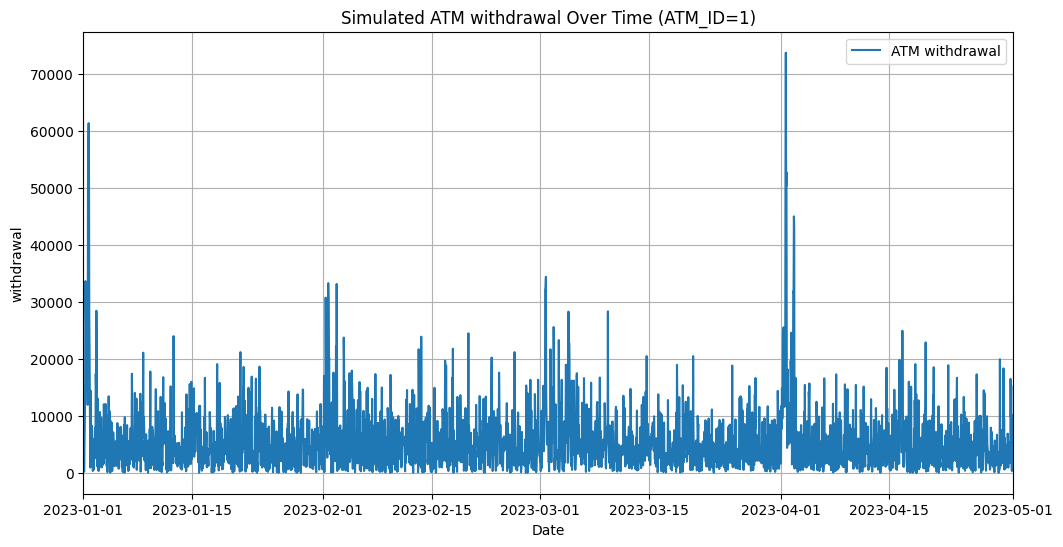

In [54]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df[df['ATM_ID'] == 1]['time'], df[df['ATM_ID'] == 1]['withdrawal'], label='ATM withdrawal')
plt.title("Simulated ATM withdrawal Over Time (ATM_ID=1)")
plt.xlabel("Date")
plt.ylabel("withdrawal")
plt.grid(True)
plt.legend()

# Set the x-axis limits
start_date = pd.to_datetime('2023-01-01')
end_date = start_date + pd.DateOffset(month=5)
plt.xlim(start_date, end_date)

# Set the y-axis limits to zoom in
# plt.ylim(6000000, 9000000)

plt.show()

In [55]:
# Get unique months from the 'time' column
unique_months = df['time'].dt.to_period('M').unique()

# Iterate over unique months and print the first day name
for month in unique_months:
    first_day = pd.to_datetime(str(month))  # Convert month to datetime
    first_day_name = first_day.strftime('%A')  # Get the day name
    print(f"First day of {month}: {first_day_name}")

First day of 2023-01: Sunday
First day of 2023-02: Wednesday
First day of 2023-03: Wednesday
First day of 2023-04: Saturday
First day of 2023-05: Monday
First day of 2023-06: Thursday
First day of 2023-07: Saturday
First day of 2023-08: Tuesday
First day of 2023-09: Friday
First day of 2023-10: Sunday
First day of 2023-11: Wednesday
First day of 2023-12: Friday


## Prophet

In [56]:
from sklearn.model_selection import train_test_split
from prophet import Prophet
import matplotlib.pyplot as plt
# m = Prophet(weekly_seasonality=False, daily_seasonality=False, n_changepoints=2)
# m = Prophet()
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# m.add_seasonality(name='rush_hours', period=1, fourier_order=3, condition_name='hourly_seasonality', condition_func=lambda x: (x >= 17) & (x <= 19))

# Load and preprocess the data
df_ATM_1 = df[df['ATM_ID'] == 1].copy()
df_ATM_1.drop('ATM_ID', axis=1, inplace=True)
df_ATM_1.rename(columns={'withdrawal': 'y', 'time': 'ds'}, inplace=True)
print('\ndf_ATM_1 length:', len(df_ATM_1))
print('\n', df_ATM_1.head(), '\n', df_ATM_1.tail())


# Split the data into 80% training and 20% testing
train_df, test_df = train_test_split(df_ATM_1, test_size=0.2, shuffle=False)

# Define and train the model
# m = Prophet()
m = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(train_df)



df_ATM_1 length: 8760

        y                  ds
0   9750 2023-01-01 00:00:00
10  3050 2023-01-01 01:00:00
20  7600 2023-01-01 02:00:00
30   200 2023-01-01 03:00:00
40  4350 2023-01-01 04:00:00 
           y                  ds
87550  1500 2023-12-31 19:00:00
87560   950 2023-12-31 20:00:00
87570   300 2023-12-31 21:00:00
87580  5800 2023-12-31 22:00:00
87590  4950 2023-12-31 23:00:00


04:45:19 - cmdstanpy - INFO - Chain [1] start processing
04:45:20 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
df_ATM_1.tail(-5)

y                  ds
50      7100 2023-01-01 05:00:00
60     12600 2023-01-01 06:00:00
70     33600 2023-01-01 07:00:00
80     30050 2023-01-01 08:00:00
90     25550 2023-01-01 09:00:00
...      ...                 ...
87550   1500 2023-12-31 19:00:00
87560    950 2023-12-31 20:00:00
87570    300 2023-12-31 21:00:00
87580   5800 2023-12-31 22:00:00
87590   4950 2023-12-31 23:00:00

[8755 rows x 2 columns]

In [58]:
# Make future dataframe for prediction (extend it to cover the test set as well)
future = m.make_future_dataframe(periods=len(test_df), freq='h')
print('\nFuture dataframe length:', len(future))
print('\n', future.head(), '\n', future.tail())





Future dataframe length: 8760

                    ds
0 2023-01-01 00:00:00
1 2023-01-01 01:00:00
2 2023-01-01 02:00:00
3 2023-01-01 03:00:00
4 2023-01-01 04:00:00 
                       ds
8755 2023-12-31 19:00:00
8756 2023-12-31 20:00:00
8757 2023-12-31 21:00:00
8758 2023-12-31 22:00:00
8759 2023-12-31 23:00:00


In [59]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat   yhat_lower    yhat_upper
8755 2023-12-31 19:00:00  10142.871154  3562.807518  16624.832868
8756 2023-12-31 20:00:00   8659.930616  2446.865241  14755.360805
8757 2023-12-31 21:00:00   8398.881733  2489.385126  14692.579384
8758 2023-12-31 22:00:00   8831.525853  2917.561342  15056.549770
8759 2023-12-31 23:00:00   9175.795526  3136.979271  15633.660165

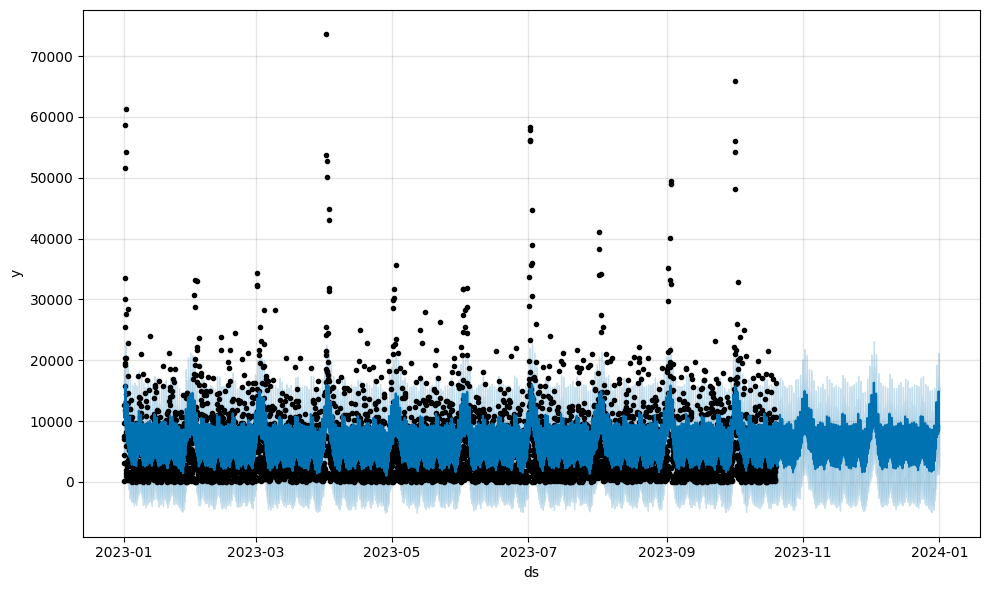

In [60]:
fig1 = m.plot(forecast)


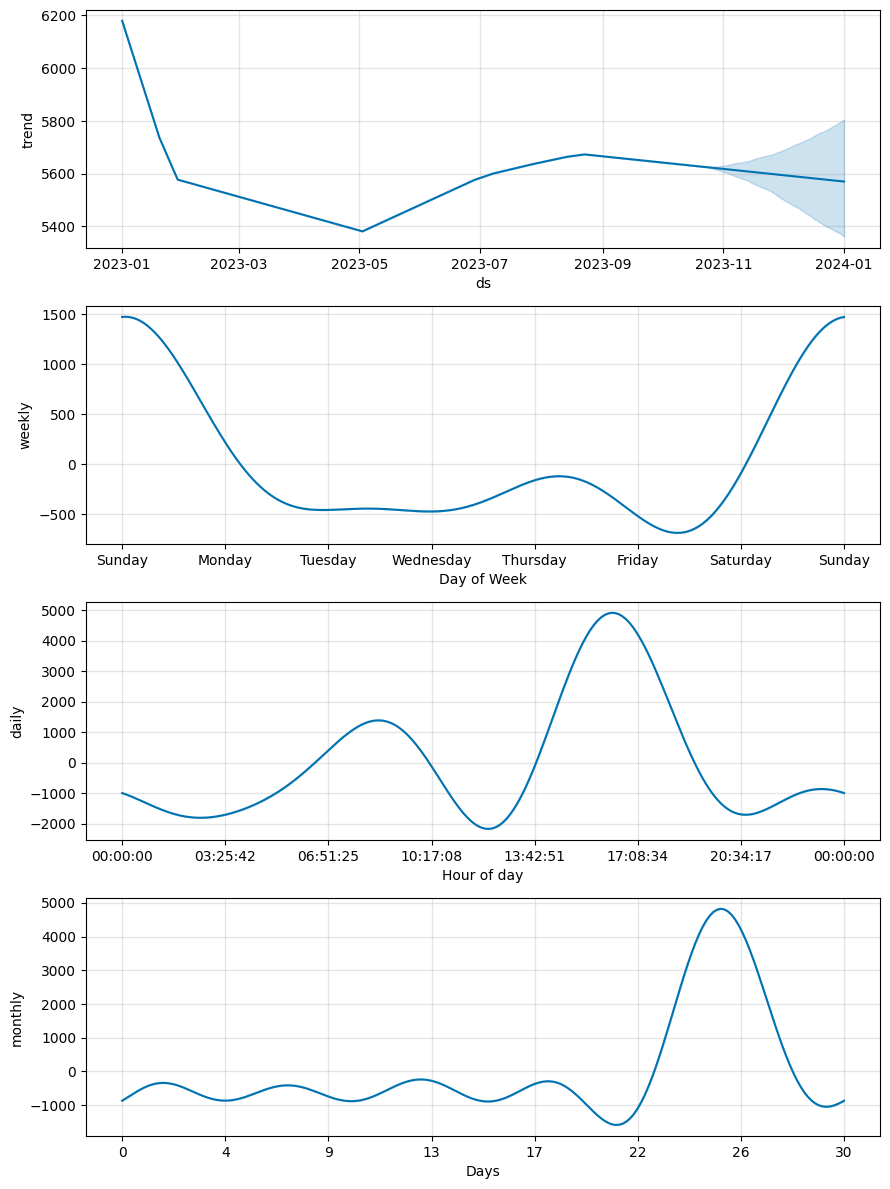

In [61]:
fig2 = m.plot_components(forecast)


                     error_percentage  error_value
time                                              
2023-01-01 00:00:00               NaN          NaN
2023-01-01 01:00:00               NaN          NaN
2023-01-01 02:00:00               NaN          NaN
2023-01-01 03:00:00               NaN          NaN
2023-01-01 04:00:00               NaN          NaN
...                               ...          ...
2023-12-31 19:00:00        576.191410  8642.871154
2023-12-31 20:00:00        811.571644  7709.930616
2023-12-31 21:00:00       2699.627244  8098.881733
2023-12-31 22:00:00         52.267687  3031.525853
2023-12-31 23:00:00         85.369607  4225.795526

[8760 rows x 2 columns]


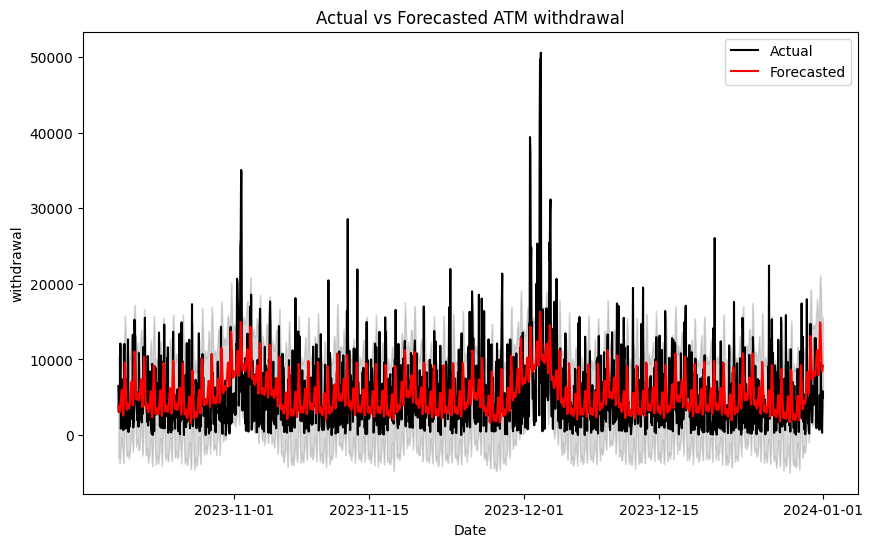

In [62]:
df_ts = pd.DataFrame(test_df)
df_ts['time'] = pd.to_datetime(df_ts['ds'])
df_ts.set_index('time', inplace=True)

df_forecast = pd.DataFrame(forecast)
df_forecast['time'] = pd.to_datetime(df_forecast['ds'])
df_forecast.set_index('time', inplace=True)

# error percentage and value
error_percentage = ((df_forecast['yhat'] - df_ts['y']) / df_ts['y']) * 100
error_value = df_forecast['yhat'] - df_ts['y']

# combine
error_df = pd.DataFrame({'error_percentage': error_percentage, 'error_value': error_value})

print(error_df)


# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='black')
plt.plot(forecast['ds'].tail(len(test_df)), forecast['yhat'].tail(len(test_df)), label='Forecasted', color='red')
plt.fill_between(forecast['ds'].tail(len(test_df)), 
                 forecast['yhat_lower'].tail(len(test_df)), 
                 forecast['yhat_upper'].tail(len(test_df)), 
                 color='gray', alpha=0.3)
plt.legend()
plt.xlabel('Date')
plt.ylabel('withdrawal')
plt.title('Actual vs Forecasted ATM withdrawal')
plt.show()


In [63]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [64]:
plot_components_plotly(m, forecast)
